In [1]:
%matplotlib inline


import copy
import cProfile
import importlib
import itertools
from IPython.display import Image
import math
import matplotlib
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import queue
import scipy.signal as signal
import subprocess
import threading 
import time


## Here is a basic correlator implimentation

In [2]:
# Adapted from: 
#https://github.com/vt-ece4530-f17/challenge-ece4530-f17-0/blob/master/challenge.pdf

class Correlator:
    def __init__(self):
        pass
    
    def myCorrelate(self,  ref, search):             
        cor = [0] * ( 1 + len(search) - len(ref))
        for i in range(0, 1 + len(search) - len(ref)):
            for j in range(0, len(ref)):
                cor[i] = cor[i] + ref[j] * search[ (i+j) % len(search) ]
        return cor

    def peakDetect(self, search):
        maxVal=-1
        maxIdx = -1

        for idx,val in enumerate(search):
            if val > maxVal:
                maxVal = val
                maxIdx = idx
                
        return maxIdx

    def bulk_peakDetect (self, references, all_searches):
        all_maxIds = []
        for ridx,reference in enumerate(references):
            ref_maxIds = []
            for search in all_searches[ridx]:
                cor = self.myCorrelate(reference,search)
                maxIdx = self.peakDetect(cor)
                ref_maxIds.append(maxIdx)
            all_maxIds.append(ref_maxIds)
        return all_maxIds

    

## Here is a simple 'reference' signal, consisting of 9 points

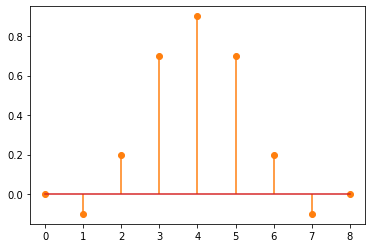

In [3]:
reference = [0,-0.1,0.2,0.7,0.9,0.7,0.2,-0.1,0] 

plt.stem(range(0, len(reference)), reference, linefmt='C1-', markerfmt='C1o')
plt.show()

## The goal of correlation is to find that 'reference' signal in a bigger 'search' signal

Here we've artifically inserted the 'reference' signal into the 'search' signal starting at index 20.  

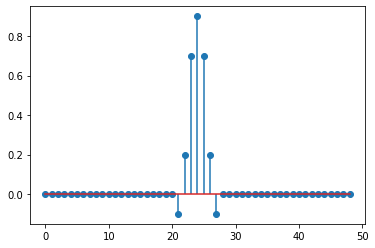

In [4]:
search = [0]*20 + reference + [0]*20


plt.stem(range(0, len(search)), search, linefmt='C0-', markerfmt='C0o')
plt.show()

## Let's run our colrrelator and see what it returns

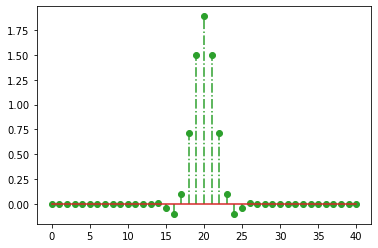

In [5]:
c = Correlator()
cor = c.myCorrelate(reference,search)
plt.stem(range(0, len(cor)), cor, linefmt='C2-.', markerfmt='C2o')
plt.show()

## Notice the the peak 'correlation' is at index 20

Correlation Values:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.010000000000000002, -0.04000000000000001, -0.09999999999999998, 0.09999999999999994, 0.7100000000000001, 1.4999999999999998, 1.8900000000000001, 1.4999999999999998, 0.7100000000000001, 0.09999999999999994, -0.09999999999999998, -0.04000000000000001, 0.010000000000000002, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Max Correlation:  1.8900000000000001
Index of Max Correlation:  20


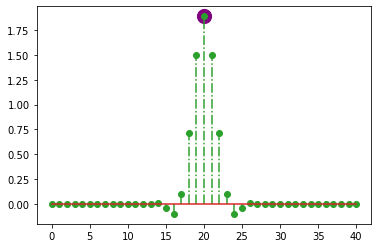

In [6]:
maxIdx = c.peakDetect(cor)
print ('Correlation Values: ', cor)
print ('Max Correlation: ', cor[maxIdx])
print ('Index of Max Correlation: ', maxIdx)

plt.scatter(maxIdx, cor[maxIdx], s=200, color='purple')
plt.stem(range(0, len(cor)), cor, linefmt='C2-.', markerfmt='C2o')
plt.show()


### This is saying that our 'reference' signal aligns most closely with index 20 of the 'search' signal. 

Let's take the origional signal, and shift it down by 20, then compare it to the 'search' signal

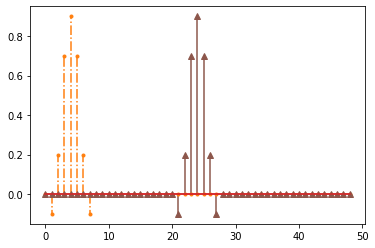

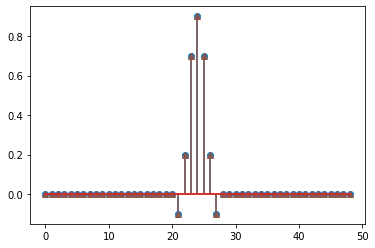

In [7]:
extended_reference = reference + [0]*(len(search)-len(reference))
shifted_reference = [0] * maxIdx + reference + [0] * (len(search)-maxIdx-len(reference))

plt.stem(range(0, len(extended_reference)), extended_reference, linefmt='C1-.', markerfmt='C1.')
plt.stem(range(0, len(shifted_reference)), shifted_reference,linefmt='C5-', markerfmt='C5^')
plt.show()

plt.stem(range(0, len(search)), search,linefmt='C0.', markerfmt='C0o')
plt.stem(range(0, len(shifted_reference)), shifted_reference,linefmt='C5-', markerfmt='C5^')
plt.show()

## Rarely are 'search' signals this clean.  Often they contain random values, or 'noise', in addition to the actual 'reference' signal.

This time we're going to start the 'reference' signal at index 35

Only Noise


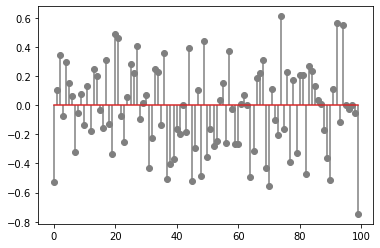

New 'search' signal containing 'reference' signal and 'noise'. 


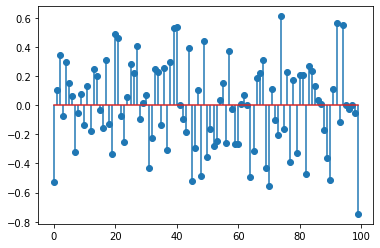

In [8]:
np.random.seed(100)
noise = np.random.normal(0,0.30,100)

print ("Only Noise")
plt.stem(range(0, len(noise)), noise, linefmt='C7-', markerfmt='C7o')
plt.show()

search = noise
ref_idx = 35
search[ref_idx:ref_idx+len(reference)] += reference

print ("New 'search' signal containing 'reference' signal and 'noise'. ")
plt.stem(range(0, len(search)), search, linefmt='C0-', markerfmt='C0o')
plt.show()

## Now let's see if correlation can still find the 'reference' signal

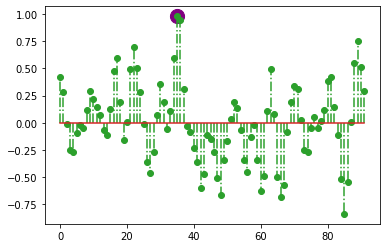

Max Correlation:  35
Correct Match: True


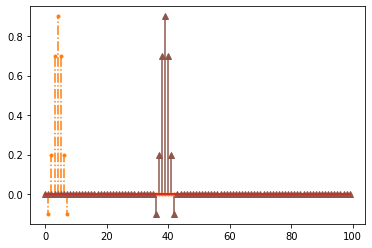

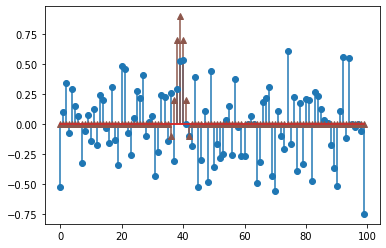

In [9]:
c = Correlator()
cor = c.myCorrelate(reference,search)
maxIdx = c.peakDetect(cor)

plt.scatter(maxIdx, cor[maxIdx], s=200, color='purple')
plt.stem(range(0, len(cor)), cor, linefmt='C2-.', markerfmt='C2o')
plt.show()

print ("Max Correlation: ", maxIdx)
print ("Correct Match:", True if ref_idx==maxIdx else False)

extended_reference = reference + [0]*(len(search)-len(reference))
shifted_reference = [0] * maxIdx + reference + [0] * (len(search)-maxIdx-len(reference))

plt.stem(range(0, len(extended_reference)), extended_reference, linefmt='C1-.', markerfmt='C1.')
plt.stem(range(0, len(shifted_reference)), shifted_reference,linefmt='C5-', markerfmt='C5^')
plt.show()

plt.stem(range(0, len(search)), search,linefmt='C0.', markerfmt='C0o')
plt.stem(range(0, len(shifted_reference)), shifted_reference,linefmt='C5-', markerfmt='C5^')
plt.show()

## It was still able to find the 'reference' signal in the noisy 'search' signal.  

## Now let's see if it can find a bunch of 'reference' signals in a bunch of 'search' signals

In [10]:
ref_len = 64
x_references = [
    signal.boxcar(ref_len)*1.2-0.5,
    signal.triang(ref_len)*1.5-0.75,
    signal.triang(ref_len*2)[:ref_len]*5 - 2.5,
    signal.chirp(np.linspace(0,1,ref_len), f0=1, f1=3, t1=1, method='linear')* 0.5,
    signal.chirp(np.linspace(0,1,ref_len), f0=0.1, f1=3, t1=1, method='linear')* 0.5,
    
    signal.chirp(np.linspace(0,1,ref_len), f0=1, f1=10, t1=1, method='linear')* 0.5,
    signal.parzen(ref_len) - 0.5,    
    signal.hamming(ref_len)-0.5,
    signal.hann(ref_len)*-1.0 -0.5,
    signal.chebwin(ref_len, at=100)-0.5,
    
    signal.gaussian(ref_len, 2)-0.5,
    signal.kaiser(ref_len,100)*1.0-0.5,
    np.cos( np.linspace(0, 1*np.pi, ref_len))*1.5, 
    np.cos( np.linspace(0, 2*np.pi, ref_len)),
    signal.impulse( ([1.0], [1.0, 0.5, 1.0]), N=ref_len)[1] * 10,
    ]
references = [ x * signal.chebwin(int(ref_len), at=100) for x in x_references ]

Run this code if you want to plot all of the reference signals
```Python
for idx, reference in enumerate(references):
    print (idx)
    plt.stem(range(0, len(x_references[idx])), x_references[idx], linefmt='C0-', markerfmt='C0o')
    plt.show()
    plt.stem(range(0, len(reference)), reference, linefmt='C1-', markerfmt='C1o')
    plt.show()
 ```

In [11]:
search_len = 256
np.random.seed(100) # so we get consistant random
noises = [
    np.random.normal(0,0.01,search_len),
    np.random.normal(0,0.05,search_len),
    np.random.normal(0,0.10,search_len),
    np.random.normal(0,0.20,search_len),
    np.random.normal(0,0.25,search_len),

    np.random.random(search_len) * 0.35 - 0.125,
    np.random.triangular(-1, 0, 1, search_len)*0.40,
    np.random.uniform(-1,1, search_len) * 0.3,
    np.random.gamma(1, 0.25, search_len) - 0.10, 
    np.random.logistic(1, 0.10, search_len) - 1.0,
    
    np.random.laplace(1, 0.15, search_len) - 1.0,
    np.cos( np.linspace(-np.pi/4, 25*np.pi, search_len)) * 0.2,
    np.cos( np.linspace(-np.pi/4, 0.1*np.pi , search_len)) * 0.2,
    np.cos( np.linspace(-np.pi/4, 0.1*np.pi , search_len)) * 0.2,
    np.cos( np.linspace(-np.pi/1, 18*np.pi , search_len)) * 0.1 
        + np.cos( np.linspace(-np.pi, 28*np.pi, search_len)) * 0.2, 
    
    np.cos( np.linspace(-np.pi, 1*np.pi , search_len)) * 0.10  
        + np.random.normal(0,0.15,search_len),
    np.cos( np.linspace(-np.pi, 0.1*np.pi , search_len)) * 0.1  
        + np.cos( np.linspace(-np.pi, 28*np.pi, search_len)) * +0.1  
        + np.random.normal(0,0.15,search_len),
    ]

positions = np.random.choice( range(0, search_len-ref_len), size=6, replace=False)

Run this code if you want to plot all of the noise signals
```Python
for idx, noise in enumerate(noises):
    print (idx)
    plt.stem(range(0, len(noise)), noise, linefmt='C7-', markerfmt='C7o')
    plt.show()

```

In [12]:
all_searches = []
for ridx, reference in enumerate(references):
    ref_searches = []
    for noise in noises:
        for position in positions:
            search = copy.deepcopy(noise)
            search[position:position+len(reference)] += reference
            ref_searches.append(search)
    all_searches.append(ref_searches)        

Run this code if you want to plot all of the search signals
```Python
for idx, searches in enumerate(all_searches):
    for jdx, search in enumerate(searches):
        print ('refernce signal #: ', idx)
        print ('noise signal #:', int(jdx/len(positions)))
        print ('position #:', jdx % len(positions))
        plt.stem(range(0, len(search)), search, linefmt='C0-', markerfmt='C0o')
        plt.show() 
```    

## Now let's use our collelator to find the 'reference' signals in the 'search' signals

In [13]:
c = Correlator()
all_peaks = c.bulk_peakDetect ( references, all_searches)

## And define a 'check' method to make sure we're correct

In [14]:
def check( all_peaks, references, noises, positions, error=3):
    
    if len(all_peaks) != len(references):
        return False
    
    correct_peaks = list(np.concatenate([positions] * len(noises)).flat)
        
    for pidx,peaks in enumerate(all_peaks):
        
        sidx = 0
        for peak, correct in zip(peaks, correct_peaks):
            
            close_enough = abs(peak-correct) <= error
            
            if not close_enough: 
                print ('Error Found: Ref:%d Search:%d' % (pidx,sidx) )
                print ('Computed Peak:', peak)
                print ('Actual Peak:', correct)

                print ('Reference #:', pidx)
                print ('Noise #:', int(sidx / len(positions)))
                print ('Position #:', sidx % len(positions))

                reference = references[pidx]
                noise = noises[ int(sidx / len(positions))]
                search = all_searches[pidx][sidx]
                position = positions[sidx % len(positions) ]

                c = Correlator()
                correlation = c.myCorrelate(reference, search)
                maxIdx = c.peakDetect(correlation)
                assert(maxIdx == peak)

                print ('Reference Signal')
                plt.stem(range(0, len(reference)), reference, linefmt='C1-', markerfmt='C1o')
                plt.show()

                print ('Noise Signal')
                plt.stem(range(0, len(noise)), noise, linefmt='C2-', markerfmt='C2o')
                plt.show()

                print ('Search Signal')
                plt.stem(range(0, len(search)), search, linefmt='C0-', markerfmt='C0o')
                plt.show()

                print ('Correlation Signal')
                plt.scatter(peak, correlation[peak], s=200, color='brown')
                plt.scatter(correct, correlation[correct], s=200, color='red')
                plt.scatter(maxIdx, correlation[maxIdx], s=200, color='orange')
                plt.stem(range(0, len(correlation)), correlation, linefmt='C4-.', markerfmt='C4o')
                plt.show()

                return False
            sidx += 1
    return True


In [15]:
correct = check(all_peaks, references, noises, positions)
print ('%s Errors Found!' % ("No" if correct else ""))

No Errors Found!


In [16]:
start = time.perf_counter()
all_peaks = c.bulk_peakDetect ( references, all_searches)
stop = time.perf_counter()

#The elapsed time is the difference between the two times
delay = stop-start
print('Total Circle Drawing Time: ' + str(delay) + ' Seconds')

correct = check(all_peaks, references, noises, positions)
print ('%s Errors Found!' % ("No" if correct else ""))

Total Circle Drawing Time: 11.498850814999997 Seconds
No Errors Found!


## Now we can profile our correlator

In [17]:
c = Correlator()
cProfile.run('c.bulk_peakDetect ( references, all_searches)')

         19204579 function calls in 13.984 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     1530    0.021    0.000    0.021    0.000 <ipython-input-2-d8c316bc8b79>:15(peakDetect)
        1    0.024    0.024   13.984   13.984 <ipython-input-2-d8c316bc8b79>:26(bulk_peakDetect)
     1530   12.598    0.008   13.938    0.009 <ipython-input-2-d8c316bc8b79>:8(myCorrelate)
        1    0.000    0.000   13.984   13.984 <string>:1(<module>)
        1    0.000    0.000   13.984   13.984 {built-in method builtins.exec}
 19199970    1.340    0.000    1.340    0.000 {built-in method builtins.len}
     1545    0.000    0.000    0.000    0.000 {method 'append' of 'list' objects}
        1    0.000    0.000    0.000    0.000 {method 'disable' of '_lsprof.Profiler' objects}




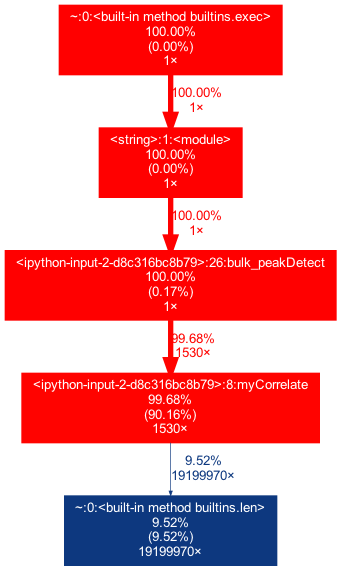

In [18]:
cProfile.run('c.bulk_peakDetect ( references, all_searches)', 'correlation.pstats')
subprocess.call(['python3', 'gprof2dot.py', '-f', 'pstats', './correlation.pstats', '-o', 'correlation.dot' ])
subprocess.call(['dot', '-Tpng', '-o', 'correlation.png', 'correlation.dot' ])
Image('correlation.png')

## Here's your starter code and its runtime

In [30]:
import MyCorrelator
importlib.reload(MyCorrelator)

# increase maxCores once your MyCorrelator supports it!
mc = MyCorrelator.MyCorrelator( maxCores = 1)
start = time.perf_counter()
all_peaks = mc.bulk_peakDetect ( references, all_searches)
stop = time.perf_counter()

#The elapsed time is the difference between the two times
delay = stop-start
print('Total Circle Drawing Time: ' + str(delay) + ' Seconds')

correct = check(all_peaks, references, noises, positions)
print ('%s Errors Found!' % ("No" if correct else ""))

Total Circle Drawing Time: 13.381196045000252 Seconds
No Errors Found!


## Your task is to acclerate this using multi-threading and/or multi-processing.  

As Multi-Threading will run against the Python Global Interpretter Lock (GIL), we suggest multi-processing.  

Here is some example code to get you started on multi-processing.  

NOTE:  this might print `hello world !`, or `world hello !` depending on what order to independent processes run. 

In [61]:
# Adapted from: 
# https://docs.python.org/3/library/multiprocessing.html#pipes-and-queues

import multiprocessing as mp
import threading
import time
import random

def echo_str(s,q):
    time.sleep(random.uniform(0,1))
    q.put(s)
    
def run_test():
    hw = ['Hello', 'World']
    ctx = mp.get_context('fork')
    q = ctx.Queue()
    ph = ctx.Process(target=echo_str, args=(hw[0],q))
    pw = ctx.Process(target=echo_str, args=(hw[1],q))
    ph.start(); pw.start()
    print(q.get(), q.get(), '!')
    ph.join(); pw.join()
    
for i in range(10):
    run_test()

Hello World !
World Hello !
Hello World !
World Hello !
Hello World !
Hello World !
World Hello !
Hello World !
Hello World !
World Hello !


In [ ]:
ref_len = 64
x_references = [
    signal.boxcar(ref_len)*1.2-0.5,
    signal.triang(ref_len)*1.5-0.75,
    signal.triang(ref_len*2)[:ref_len]*5 - 2.5,
    signal.chirp(np.linspace(0,1,ref_len), f0=1, f1=3, t1=1, method='linear')* 0.5,
    signal.chirp(np.linspace(0,1,ref_len), f0=0.1, f1=3, t1=1, method='linear')* 0.5,
    
    signal.chirp(np.linspace(0,1,ref_len), f0=1, f1=10, t1=1, method='linear')* 0.5,
    signal.parzen(ref_len) - 0.5,    
    signal.hamming(ref_len)-0.5,
    signal.hann(ref_len)*-1.0 -0.5,
    signal.chebwin(ref_len, at=100)-0.5,
    
    signal.gaussian(ref_len, 2)-0.5,
    signal.kaiser(ref_len,100)*1.0-0.5,
    np.cos( np.linspace(0, 1*np.pi, ref_len))*1.5, 
    np.cos( np.linspace(0, 2*np.pi, ref_len)),
    signal.impulse( ([1.0], [1.0, 0.5, 1.0]), N=ref_len)[1] * 10,
    ]
references = [ x * signal.chebwin(int(ref_len), at=100) for x in x_references ]

In [ ]:
signal.chirp(np.linspace(0,1,ref_len), f0=0.1, f1=3, t1=1, method='linear')* 0.5